# Imports

In [1]:
#Imports
%matplotlib widget
import pandas as pd
import numpy as np
import csv
import matplotlib
import matplotlib.pyplot as plt
import scipy
import datetime
import networkx as nx
import misc
import math
import random
import SmallBucket
import BigBucket
import RandomWarmUp1
import StaticDynamic

# Data Generation

In [2]:
#Create empty graph
G = nx.Graph()

In [3]:
G.add_nodes_from([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

G.add_edges_from([
    (0,1),
    (1,2),
    (2,3),
    (3,4),
    (4,5),
    (5,6),
    (6,7),
    (7,8),
    (8,9),
    (9,0),

    (0,2),
    (0,3),
    (0,4),
    (1,3)
])

In [4]:
G = nx.Graph()

In [187]:
def createRandomGraph(size=30, density=0.5, variation=0.5, maxDegree=None, sizeVariation=None, densityVariation=None, maxDegreeVariation=None):

    G = nx.Graph() 

    # Variation parameters decide how much randomness is used in the generation of the graph
    # There is a general variation parameter and three specific ones: if the specific variation is None, it is assigned the general variation
    # Variation must be between 0 and 1, where 0 means no variation and 1 means the values may vary as much as the value itself (thus, range from 0 to 2*value)
    if sizeVariation == None:
        sizeVariation = variation
    if densityVariation == None:
        densityVariation = variation
    if maxDegreeVariation == None:
        maxDegreeVariation = variation
    
    # Do some input tests to see if parameters are correct
    if size < 0 or density < 0 or density > 1 or \
        variation < 0 or variation > 1 or \
        sizeVariation < 0 or sizeVariation > 1 or \
        densityVariation < 0 or densityVariation > 1 or \
        maxDegreeVariation < 0 or maxDegreeVariation > 1:
            print("Incorrect parameter passed, returning empty graph")
            return G

    # Finalize values for graph creation by using randomness
    fSizeVariation = random.uniform(-sizeVariation, sizeVariation)
    fSize = int(max(2, size + (fSizeVariation*size)))
    
    densityRange = (max(0, density-densityVariation*density), min(1, density+densityVariation*density))
    fDensity = random.uniform(densityRange[0], densityRange[1])
    print(fDensity)
    fEdges = int(fDensity * fSize*(fSize-1) / 2)
    fDensity = 2*fEdges / (fSize*(fSize-1))

    fMaxDegree = None
    if maxDegree != None:
        print("maxDegreeRange not correct") # TODO fix this
        maxDegreeRange = (max(math.ceil(fDensity*(fSize-1)), maxDegree-maxDegreeVariation*maxDegree)), min(min(fSize-1, fEdges), maxDegree+maxDegreeVariation*maxDegree)
        print("range for max degree is " + str(maxDegreeRange[0]) + ", " + str(maxDegreeRange[1]))
        fMaxDegree = int(random.uniform(maxDegreeRange[0], maxDegreeRange[1]))

    # Start creation of the graph using finalized parameters
    # Create the graphs vertices
    for i in range(0, fSize):
        G.add_node(i)

    allEdges = []
    for i in range(0, fSize):
        for j in range(0, fSize):
            if i > j:
                allEdges.append((i,j))

    # Create the graphs edges
    edgeSet = []

    # If we require a certain max degree first ensure one node fulfills this requirement
    if fMaxDegree != None:

        # Create an array which keeps track of the current degree of each node
        degreeCounter = []
        for i in range(0, fSize):
            degreeCounter.append(0)
        
        # Pick one node to give max degree
        node = random.randint(0, fSize-1)

        # Get all potential edges for this node and select the correct amount of them
        maxNodeEdges = []
        for edge in allEdges:
            if node in edge:
                maxNodeEdges.append(edge)
        print("trying to sample " + str(fMaxDegree) + " nodes from a set of size " + str(len(maxNodeEdges)))
        edgeSet = random.sample(maxNodeEdges, fMaxDegree)
        degreeCounter[node] = fMaxDegree    # Update the selected node counter
        for edge in maxNodeEdges:           # Remove all edges connected to the selected node from the available edge set
            allEdges.remove(edge)

        # For the remaining edges, select at random while keeping track of counters
        remainingEdges = fEdges - fMaxDegree
        while remainingEdges > 0:
            edge = random.sample(allEdges, 1)[0]
            if degreeCounter[edge[0]] < fMaxDegree and degreeCounter[edge[1]] < fMaxDegree:
                edgeSet.append(edge)
                degreeCounter[edge[0]] += 1
                degreeCounter[edge[0]] += 1
                remainingEdges -= 1
            allEdges.remove(edge)

    # If the max degree is not specified simply select the correct amount of random edges
    else:
        edgeSet = random.sample(allEdges, fEdges)

    G.add_edges_from(edgeSet)

    return G

In [190]:
G = createRandomGraph(sizeVariation=0, density=1, maxDegree=20)
misc.graphInfo(G)

0.7811048938578211
maxDegreeRange not correct
range for max degree is 22.6, 29
trying to sample 25 nodes from a set of size 29


ValueError: Sample larger than population or is negative

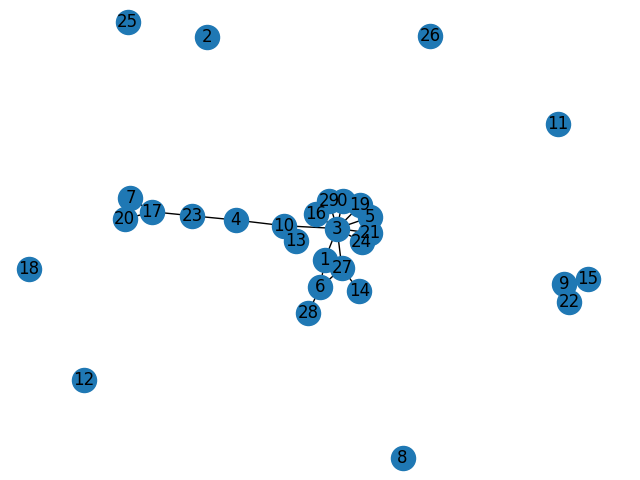

In [138]:
misc.draw(G)

# Common items

In [7]:
# Returns a coloring dictionary by combining the two available colorings
def getColoring() -> dict:
    coloring: dict = {}
    sColoring = staticColoring
    dColoring = DBB.getColoring()

    for node in G.nodes():
        coloring[node] = (sColoring[node], dColoring[node])
    return coloring

In [8]:
# Print the current situation of the leveled segment data structure
def printLevels():
    print("l: " + str(l))
    print("c: " + str(c))

# Algorithm Specific Methods

In [9]:
def removeEdge(s, t):
    if not G.has_edge(s, t):    # Potentially redundant
        print("Edge not present in graph")
        return
    G.remove_edge(s, t)
    if DBB.G.has_edge(s, t):
        DBB.removeEdge(s, t)
    updateStep()

def removeVertex(v):

    if not G.has_node(v):   # Potentially redundant
        print("Node not present in graph")
        return
    G.remove_node(v)
    DBB.removeVertex(v)
    updateStep()

def addEdge(s, t):

    if G.has_edge(s, t):    # Potentially redundant, but could be extended to also check if the vertices are present yet
        print("Edge already in the graph")
        return
    if (not G.has_node(s) or not G.has_node(t)):
        print("Not all nodes present in graph yet")
        return

    G.add_edge(s, t)
    DBB.G.add_edge(s, t)       # Add edge to G' directly, without running the dynamic algorithm

    # Increase recent degree of endpoints
    G.nodes[s]['recentDegree'] += 1
    G.nodes[t]['recentDegree'] += 1

    updateStep()               # Run update step in which the static algorithm is potentially ran

    if DBB.G.has_edge(s, t):    # If edge still in G' after update step, run dynamic algorithm
        DBB.removeEdge(s, t)
        dynamicBlackBox(s, t) 

    # Add node with highest recent degree to active level node sets
    if G.number_of_nodes() > 0:
        rd = -1
        n = None
        for node in G.nodes():
            if G.nodes[node]['recentDegree'] > rd:
                rd = G.nodes[node]['recentDegree']
                n = node
        for level in levels:
            if level[1]:
                level[0].add(n)

def addVertex(v):
    if G.has_node(v):   # Potentially redundant, depending on the input used during the experiments
        print("Node already present in graph")
        return
    G.add_node(v)
    staticColoring[v] = 'L0C0'
    G.nodes[v]['recentDegree'] = 0
    DBB.addVertex(v)
    updateStep()

In [10]:
sda = StaticDynamic.StaticDynamicAlgo(G)

In [11]:
c1 = sda.getColoring()

sda.addEdge(7,9)

c2 = sda.getColoring()
misc.numberOfRecolors(c1, c2)

Edge already in the graph


0

In [12]:
sda.getColoring()

{0: ('L0C5', 0),
 1: ('L0C2', 0),
 2: ('L0C3', 0),
 3: ('L0C7', 0),
 4: ('L0C3', 0),
 5: ('L0C9', 0),
 6: ('L0C0', 0),
 7: ('L0C1', 0),
 8: ('L0C6', 0),
 9: ('L0C6', 0),
 10: ('L0C2', 0),
 11: ('L0C8', 0),
 12: ('L0C0', 0),
 13: ('L0C4', 0),
 14: ('L0C8', 0),
 15: ('L0C9', 0),
 16: ('L0C8', 0),
 17: ('L0C5', 0),
 18: ('L0C0', 0),
 19: ('L0C8', 0),
 20: ('L0C4', 0),
 21: ('L0C1', 0),
 22: ('L0C6', 0),
 23: ('L0C5', 0),
 24: ('L0C4', 0)}

In [13]:
sda.printLevels()

l: 5
c: 0
Last Updated Level: 0
Max Level: 4


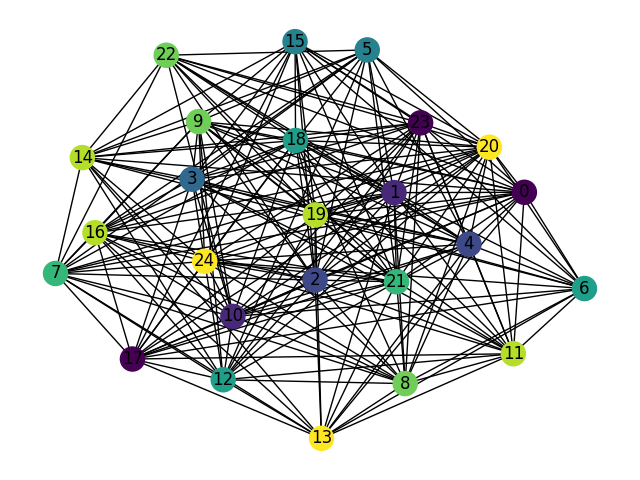

In [14]:
misc.draw(sda.G, sda.getColoring())